# Ray Dalio's Holy Grail

Reducing return/risk ratio through diversification.

From https://www.investopedia.com/video/play/ray-dalio-his-portfolio-holy-grail/

In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import altair as alt

In [2]:
def correlated_streams(n, risk, corr):
    # Assuming 10% average return
    # Benchmark avg return 10%, avg std %15
    means = np.full(n, 10, dtype=np.dtype("d"))
    bench_std = 15
    num_samples = 10_000
    
    corr_mat = np.diag(np.full(n, 9.9, dtype=np.dtype("d")))
    corr_mat += 0.1
    corr_mat = corr_mat / 10
    corr_mat[0] = corr_mat[:,0] = corr
    corr_mat[0,0] = 1
    stds = np.full(n, risk)
    stds[0] = bench_std
    stds_mat = np.diag(stds)
    cov_mat = stds_mat @ corr_mat @ stds_mat
    
    streams = np.random.multivariate_normal(means, cov_mat, size=num_samples, tol=0.01)
    
    return (streams[:,0], streams[:,1:])

In [3]:
def aggregate_risk(return_streams, n):
    """Returns the pooled risk (std) of the `n` first streams 
    in `return_streams`
    """
    aggregate_returns = np.sum(return_streams[:,:n], axis=1) / n
    return aggregate_returns.std()

In [4]:
max_assets = 20
assets = range(1, max_assets+1)
risk_levels = range(1, 15)
index = pd.MultiIndex.from_product([risk_levels, assets], names=["risk_level", "num_assets"])

simulated_data = pd.DataFrame(index=index)

for risk in risk_levels:
    for corr in np.arange(0.1, .7, 0.1):
        benchmark, return_streams = correlated_streams(max_assets, risk, corr)
        risk_level = np.zeros(max_assets)
        for num_assets in assets:
            risk_level[num_assets-1] = aggregate_risk(return_streams, num_assets)
        simulated_data.loc[(risk, ), round(corr, 1)] = risk_level
        
simulated_data.columns.names = ["correlation"]

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: covariance is not symmetric positive-semidefinite.


In [5]:
def plot_risk_level(data, risk_level):
    subset = simulated_data.query("risk_level == @risk_level")
    stacked = subset.stack().reset_index(name="risk")
    stacked.head()
    
    chart = alt.Chart(data=stacked)

    highlight = alt.selection(type="single", on="mouseover",
                              fields=["correlation"], nearest=True)

    base = chart.encode(
                alt.X("num_assets", axis=alt.Axis(title="Number of Assets")),
                alt.Y("risk", axis=alt.Axis(title="Risk %")),
                alt.Color("correlation:N", scale=alt.Scale(scheme="set2")))

    points = base.mark_circle().encode(
        opacity=alt.value(0)
    ).add_selection(
        highlight
    ).properties(
        width=600,
        title="Risk % by number of assets in portfolio"
    )

    lines = base.mark_line().encode(
        size=alt.condition(~highlight, alt.value(1), alt.value(3)),
        tooltip=["correlation"]
    )

    return points + lines

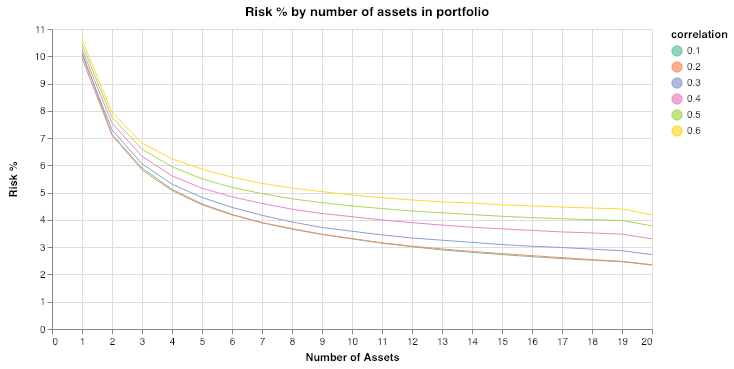

In [6]:
plot_risk_level(simulated_data, 10)

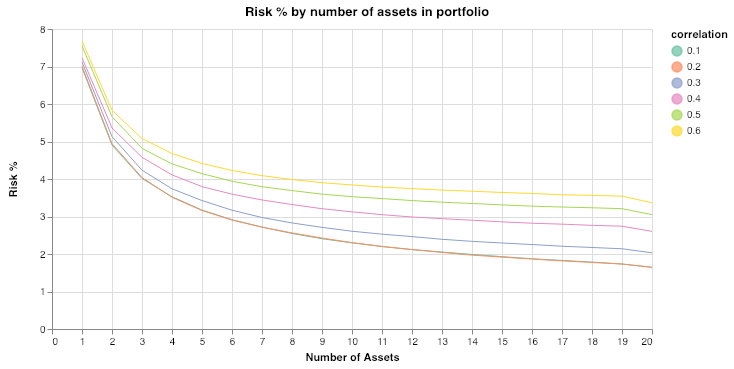

In [7]:
plot_risk_level(simulated_data, 7)